# **Data Load**

In [ ]:
#Data를 가져오기 위해 Google drive mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#2017 AF-related GWAS data read 
import pandas as pd
df = pd.read_table('/content/drive/MyDrive/IndividualStudy/2017.txt', sep="\t")

# **Data 3분할(GWAS, TWAS, EWAS)**

In [ ]:
#데이터를 삼등분해서 앞의 1/3만 GWAS data로 한정 및 가정
#이 과정에서 markerName과 p.value만을 가져온다.
#이후 정규분포 누적분포함수의 역함수의 계산을 위해 평균과 표준편차를 계산
GWAS = df.iloc[0:3930687,[0,7]]
GWAS_list = GWAS.values.tolist()
print(GWAS.head())
print(GWAS['P.value'].mean()) #0.49
print(GWAS['P.value'].std())  #0.29

    MarkerName  P.value
0   rs58108140  0.27400
1  rs180734498  0.05506
2  rs144762171  0.01655
3  rs140337953  0.43300
4  rs116400033  0.69730
0.4919302829061179
0.29164709625116814


In [ ]:
#데이터를 삼등분해서 중간의 1/3만 EWAS data로 가정
#이 과정에서 p.value만을 가져온다.
#이후 정규분포 누적분포함수의 역함수의 계산을 위해 평균과 표준편차를 계산
EWAS = df.iloc[3930687:7861374,7]
EWAS_list = EWAS.values.tolist()
print(EWAS.head())
print(EWAS.mean()) #0.49
print(EWAS.std())  #0.29

3930687    0.001414
3930688    0.342200
3930689    0.656200
3930690    0.011230
3930691    0.882000
Name: P.value, dtype: float64
0.4926911756166191
0.29130324307148187


In [ ]:
#데이터를 삼등분해서 중간의 1/3만 TWAS data로 가정
#이 과정에서 p.value만을 가져온다.
#이후 정규분포 누적분포함수의 역함수의 계산을 위해 평균과 표준편차를 계산
TWAS = df.iloc[7861374:11792061,7]
TWAS_list = TWAS.values.tolist()
print(TWAS.head())
print(TWAS.mean()) #0.48
print(TWAS.std())  #0.29

7861374    0.5988
7861375    0.5033
7861376    0.5049
7861377    0.9784
7861378    0.5056
Name: P.value, dtype: float64
0.48865252964505745
0.2915450244878491


In [ ]:
#위 과정을 통해서 얻어낸 데이터의 형태
print(GWAS_list[0])
print(EWAS_list[0])
print(TWAS_list[0])

['rs58108140', 0.274]
0.001414
0.5988


# **각 P-value를 이용한 Z-score 및 종합 Pmeta 값 계산**

In [ ]:
import math
def normal_cdf(x, mu=0, sigma=1):
    return (1+math.erf((x-mu)/math.sqrt(2)/sigma))/2

# 정규분포 누적분포함수의 역함수
def inverse_normal_cdf(p, mu=0, sigma=1, tolerance=0.00001):
    '''이진검색을 사용해서 역함수 근사'''

    # 표준정규분포가 아니라면 표준정규분포로 변환
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)

    low_z, low_p = -10.0, 0 # normal_cdf(-10)는 0에 근접
    hi_z, hi_p = 10.0, 1 # normal_cdf(10)는 1에 근접

    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2 # 중간 값
        mid_p = normal_cdf(mid_z) # 중간 값의 누적분포 값을 계산
        if mid_p < p:
            # 중간 값이 너무 작다면 더 큰 값들을 검색
            low_z, low_p = mid_z, mid_p
        elif mid_p > p:
            # 중간 값이 너무 크다면 더 작은 값들을 검색
            hi_z, hi_p = mid_z, mid_p
        else:
            break

    return mid_z

In [ ]:
#여러 omics data 각각의 Zi값을 계산
Zi = []
for i in range(0,3930687):
    GWAS_Zi = inverse_normal_cdf(GWAS_list[i][1], 0.49, 0.29)
    EWAS_Zi = inverse_normal_cdf(EWAS_list[i], 0.49, 0.29)
    TWAS_Zi = inverse_normal_cdf(TWAS_list[i], 0.48, 0.29)
    Zi.append([GWAS_list[i][0], GWAS_Zi, EWAS_Zi, TWAS_Zi])

In [ ]:
#계산된 각각의 Zi값
print(Zi[0])

['rs58108140', 0.315777530670166, -0.37589632034301756, 0.5525680351257324]


In [ ]:
#논문에서 사용한 각 omics 데이터 크기별 weight
wi_GWAS = 17391**(1/3.8)
wi_EWAS = 183**(1/2)
wi_TWAS = 177**(1/2)
print(wi_GWAS)
print(wi_EWAS)
print(wi_TWAS)

13.057946439983974
13.527749258468683
13.30413469565007


In [ ]:
#Zmeta 값의 계산
import numpy as np
Z_meta = []
Z_meta_denominator = (wi_GWAS**2 + wi_EWAS**2 + wi_TWAS**2)**(1/2)
for i in range(0,3930687):
  Z_meta_numerator = wi_GWAS*Zi[i][1] + wi_EWAS*Zi[i][2] + wi_TWAS*Zi[i][3]
  Z_meta.append(Z_meta_numerator/Z_meta_denominator)

Z_meta_mean = np.mean(Z_meta)
Z_meta_std = np.std(Z_meta)
print(Z_meta_mean) #0.82
print(Z_meta_std)  #0.3

0.8244589388132382
0.29805632923453407


In [ ]:
#Zmeta값을 이용한 최종 Pmeta값 계산
P_meta = []
for i in range(0,3930687):
  P_meta.append(normal_cdf(Z_meta[i], 0.82, 0.3))

# **Bon-ferroni correction을 통한 AF 관련 SNP 추출**

In [ ]:
#Bon-ferroni correction을 위한 기준값 설정
M = 14364
bon_cor = 0.05/M

In [ ]:
#Bon-ferroni correction에 부합하는 데이터만을 추출
result = []
for i in range(0,3930687):
  if P_meta[i] < bon_cor:
    result.append([Zi[i][0], P_meta[i]])

In [ ]:
print(len(result)) #최종 추출된 SNP 수

357


In [ ]:
#최종 추출된 SNP를 파일로 저장
with open('meaningful_P_meta.txt','w',encoding='UTF-8') as f:
    for rowdata in result:
        f.write(rowdata[0]+'\t'+str(rowdata[1])+'\n')

# **SNP가 포함된 유전자명 추출**

In [ ]:
!pip install easy_entrez #SNP를 통해서 유전자명을 추출하는 api 사용을 위한 라이브러리 설치

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from easy_entrez import EntrezAPI

genes_related_AF = []
entrez_api = EntrezAPI('Project name', 'your@mail.com')

#위에서 구한 SNP 이름을 통한 유전자명 추출
for i in range(0,357):
  rs = entrez_api.fetch([result[i][0]], max_results=1, database='snp').data
  namespaces = {'ns0': 'https://www.ncbi.nlm.nih.gov/SNP/docsum'}
  genes = [
           name.text
           for name in rs.findall('.//ns0:GENE_E/ns0:NAME', namespaces)
    ]
  genes_related_AF.append([result[i][0], result[i][1], genes])  #[markerName, P_meta, gene_name]

In [ ]:
#유전자명이 추출된 데이터만을 확보
only_genes = []
for i in range(0, len(genes_related_AF)):
  if len(genes_related_AF[i][2])!=0:
    only_genes.append(genes_related_AF[i][2][0])

In [ ]:
#중복되는 유전자 이름을 하나만 남기고 제거
only_genes_nodup = []
only_genes_nodup = list(set(only_genes))
#최종 AF와 관련되어있다고 판별된 유전자명 파일에 저장
with open('Genes_related_AF.txt','w',encoding='UTF-8') as f:
    for rowdata in only_genes_nodup:
        f.write(rowdata+'\n')

# **논문과 직접 구한 결과와의 비교**

In [ ]:
#논문에서 판별한 AF 관련 유전자명
AF_related_gene = ['KCNN3', 'PMVK', 'PBXIP1', 'PYGO2', 'SHC1', 'FLAD1', 'LENEP', 'ZBTB7B', 'DCST2', 'DCST1', 'PRRX1', 'CEP68', 'RAB1A', 'ANXA4', 'GMCL1', 'SNRNP27', 'MXD1', 'ASPRV1', 'PLEKHA3', 'PITX2', 'SEC31A', 'THAP9', 'LIN54', 'COPS4', 'ENPEP', 'HNRNPA0', 'MYOT', 'PKD2L2', 'FAM13B', 'WNT8A', 'CAV1', 'CAV2', 'FBXO32', 'SH3PXD2A', 'SEC24C', 'CHCHD1', 'NDST2', 'TBX5', 'ESR2', 'HCN4', '2FHX3', 'MED24', 'THRA', 'CSF3']
#위 과정을 거치면서 판별한 AF 관련 유전자 명과 논문에서 판별한 AF 관련 유전자 명을 비교
same_result = []
count = 0
for i in range(0,len(only_genes_nodup)):
  if only_genes_nodup[i] in AF_related_gene:
    count+=1
    same_result.append(only_genes_nodup[i])
same_result.append(count)

In [ ]:
#논문과 직접 구한 결과에서 공통으로 판별된 AF 관련 유전자 명과 총 갯수를 파일에 저장
with open('Final_Result.txt','w',encoding='UTF-8') as f:
    for rowdata in same_result:
        f.write(str(rowdata)+'\n')

# **[SNP, Pmeta, 유전자명] 데이터 추출**

In [ ]:
#유전자명이 추출된 데이터만을 확보
SNP_Pmeta_genes = []
for i in range(0, len(genes_related_AF)):
  if len(genes_related_AF[i][2])!=0:
    SNP_Pmeta_genes.append([genes_related_AF[i][0], genes_related_AF[i][1], genes_related_AF[i][2][0]])

In [ ]:
#최종 AF와 관련되어있다고 판별된 SNP, 해당 SNP의 P_meta, 유전자명을 한 row로 해서 파일에 저장
with open('SNP_Pmeta_gene.txt','w',encoding='UTF-8') as f:
    for rowdata in SNP_Pmeta_genes:
        f.write(rowdata[0]+'\t'+str(rowdata[1])+'\t'+rowdata[2]+'\n')

# **{유전자명:[유전자명에 해당하는 SNP의 Pmeta]} 데이터 저장**

In [ ]:
Pmeta_by_Gene = {}
for i in range(0, len(SNP_Pmeta_genes)):
  if SNP_Pmeta_genes[i][2] in Pmeta_by_Gene.keys():
    Pmeta_by_Gene[SNP_Pmeta_genes[i][2]].append(SNP_Pmeta_genes[i][1])
  else:
    Pmeta_by_Gene[SNP_Pmeta_genes[i][2]] = [SNP_Pmeta_genes[i][1]]
print(Pmeta_by_Gene[SNP_Pmeta_genes[0][2]])

[2.4044702359171666e-06, 3.0603639273318883e-06, 2.358699864368763e-06]


# **각 유전자별 평균 Pmeta값 계산**

In [ ]:
final_Pmeta_by_Gene = {}
for i in Pmeta_by_Gene.keys():
  final_Pmeta_by_Gene[i] = math.log10(np.mean(Pmeta_by_Gene[i])**(-1))
print(final_Pmeta_by_Gene)

{'RHBDL2': 5.583718278898805, 'SZT2': 5.487141632026625, 'NTNG1': 6.021951535525281, 'S100A1': 6.054077221562974, 'ILF2': 5.5322379982446135, 'KCNN3': 5.9973292087517915, 'PMVK': 5.667842408580454, 'ZBTB7B': 5.649943338424628, 'LOC105371610': 5.833341148661386, 'PRRX1': 5.81145087882248, 'CACNA1E': 5.873322311853157, 'ASAP2': 5.527030227798608, 'LOC105369165': 5.827047822041748, 'GMCL1': 5.998992658381313, 'SNRNP27': 6.043518072490449, 'MXD1': 6.170332792069963, 'FAM136A': 6.162900197331494, 'LINC01965': 6.301558039583687, 'LIMS1': 5.755262819159963, 'LOC100130691': 6.375070002533411, 'AGPS': 5.935054948456267, 'TTN': 5.733362225352597, 'ZNF385B': 7.233485845902694, 'ABCA12': 5.69730753060232, 'EEF1DP3': 6.053444465994922, 'TMEM40': 6.56386330651457, 'CAND2': 6.172231672825884, 'PTPN23': 5.663462632348687, 'SCAP': 6.351356991415154, 'ELP6': 5.523981342167063, 'CACNA1D': 5.494400544809405, 'LOC105374557': 5.576650889313025, 'PANCR': 6.518646288996016, 'PITX2': 6.1107116140133515, 'MIR29

# **SNP가 속한 염색체 번호 추출**

In [ ]:
from pandas import DataFrame

temp = []
for i in range(0,357):
  temp.append(result[i][0])

response = entrez_api.fetch(temp, max_results=357, database='snp')

variant_positions = DataFrame([
    {
        'id': 'rs' + document_summary.get('uid'),
        'chromosome': chromosome,
        'position': position
    }
    for document_summary in response.data
    for chrom_and_position in document_summary.findall('.//ns0:CHRPOS', namespaces)
    for chromosome, position in [chrom_and_position.text.split(':')]
])

In [ ]:
chromosome = variant_positions.values.tolist()
print(chromosome)

[['rs7545590', '1', '38926996'], ['rs112431167', '1', '38928788'], ['rs11810286', '1', '38933626'], ['rs11810357', '1', '38951731'], ['rs9662216', '1', '38952689'], ['rs12125131', '1', '38956048'], ['rs115299159', '1', '38956790'], ['rs6657271', '1', '38960910'], ['rs74574313', '1', '43402169'], ['rs2093194', '1', '86512798'], ['rs7547969', '1', '107162063'], ['rs6675402', '1', '109948590'], ['rs3790411', '1', '153630385'], ['rs11265625', '1', '153670433'], ['rs34292822', '1', '154839924'], ['rs36088503', '1', '154840467'], ['rs11588763', '1', '154841108'], ['rs12740456', '1', '154841721'], ['rs6658392', '1', '154842575'], ['rs6426988', '1', '154842844'], ['rs36004974', '1', '154845927'], ['rs11586348', '1', '154846883'], ['rs12089941', '1', '154855044'], ['rs11264280', '1', '154890476'], ['rs4578216', '1', '154928245'], ['rs6673081', '1', '155017119'], ['rs6658866', '1', '170591463'], ['rs6659754', '1', '170592263'], ['rs577827', '1', '170593942'], ['rs763567', '1', '170596864'], ['rs

# **유전자와 유전자가 속한 염색체 번호 추출**

In [ ]:
#SNP_Pmeta_genes - [markerName, P_meta, gene_name]
#chromosome - [markerName, chromosome_number, id]
gene_to_chromosome = {}
for i in range(0, len(SNP_Pmeta_genes)):
  for j in range(0, len(chromosome)):
    if SNP_Pmeta_genes[i][0] == chromosome[j][0]:
      gene_to_chromosome[SNP_Pmeta_genes[i][2]] = chromosome[j][1]

print(gene_to_chromosome)

{'RHBDL2': '1', 'SZT2': '1', 'NTNG1': '1', 'S100A1': '1', 'ILF2': '1', 'KCNN3': '1', 'PMVK': '1', 'ZBTB7B': '1', 'LOC105371610': '1', 'PRRX1': '1', 'CACNA1E': '1', 'ASAP2': '2', 'LOC105369165': '2', 'GMCL1': '2', 'SNRNP27': '2', 'MXD1': '2', 'FAM136A': '2', 'LINC01965': '2', 'LIMS1': '2', 'LOC100130691': '2', 'AGPS': '2', 'TTN': '2', 'ZNF385B': '2', 'ABCA12': '2', 'TMEM40': '3', 'CAND2': '3', 'PTPN23': '3', 'SCAP': '3', 'ELP6': '3', 'CACNA1D': '3', 'LOC105374557': '4', 'PANCR': '4', 'PITX2': '4', 'MIR297': '4', 'PDGFC': '4'}


In [ ]:
print(len(gene_to_chromosome))  #유전자명 : 염색체 번호

35


# **각 염색체별 AF 관련 유전자의 Pmeta값 시각화**

In [ ]:
#Bon-ferroni correction을 위한 기준값 설정
standard = math.log10(bon_cor**(-1))
print(standard)

5.4583053921180165


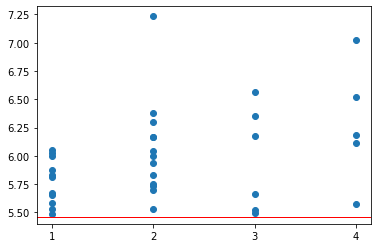

In [ ]:
import matplotlib.pyplot as plt

gene_list = list(gene_to_chromosome.keys())
x_values = []
y_values = []
for i in gene_list:
  x_values.append(gene_to_chromosome[i])
  y_values.append(final_Pmeta_by_Gene[i])
plt.scatter(x_values, y_values)
plt.axhline(y=standard, color='r', linewidth=1)
plt.show()